# Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Use of machine learning techniques for heavenly bodies classification based on Sloan Digital Sky Survey

## Wprowadzenie
W tym notebooku spróbujemy przeprowadzić klasyfikację obiektów niebieskich jako gwiazdę, galaktykę lub kwazar. W tym celu spróbujemy kompletnego podejścia jakim kierują się ludzie z działu tzw. Data Science. Na to podejście będzie się analiza danych, wybór cech, proces uczenia maszynowego wraz z selekcją cech oraz analiza otrzymanych wyników.

Cały proces zostanie przeprowadzony na zbiorze Sloan Digital Sky Survey.
### O zbiorze danych

Sloan Digital Sky Survey jest projektem, który oferuje publicznie dostępne dane o obserwacjach obiektów niebieskich. Dane te były zbierane od 1998r. i zostały udostępnione dla każdego, kto był zainteresowany.

Dla tego celu wykorzystany został specjalny teleskop od średnicy 2.5m, który zbudowano w Nowym Meksyku w obserwatorium Apache Point Observatory w USA. Teleskop używa kamery składającej się z 30 chipów CCD o rozdzielczości 2048x2048 każdy. Chipy są ułożone w 5 rzędów po 6 w każdym. Każdy rząd obserwuje przestrzeń kosmiczną przez różne optyczne filtry (u, g, r, i, z) w różnych długościach fal - 354, 476, 628, 769, 925 nm.

Teleskop pokrywa swym zasięgiem około 1/4 ziemskiego nieba - przez co skupia swój wzrok na północnej części nieba.


## Opis zbioru danych

### Zawartość
Zbiór składa się z 10 tys. obserwacji ciał niebieskich zebranych przez SDSS. Każda obserwacja jest opisana przez 17 atrybutów i jednej klasy przynależności - gwiazda, galaktyka lub kwazar.

### Opis cech

Zbiór powstał poprzez wykonanie kwerendy, która łączy ze sobą dwa widoki SQL. "PhotoObj", który zawiera fotometryczne dane oraz "SpecObj" zawierający dane spektralne.

View "PhotoObj"<br>
* **objid = Object Identifier**<br>
* **ra = J2000 Right Ascension (r-band)**<br>
* **dec = J2000 Declination (r-band)**<br>

Rektascensja, α (łac. recta ascensio – "wznoszenie proste") – jedna ze współrzędnych astronomicznych, określających położenie ciała niebieskiego na sferze niebieskiej w układzie współrzędnych astronomicznych zwanym układem równikowym równonocnym.

Definiujemy ją jako kąt dwuścienny pomiędzy płaszczyzną koła godzinnego punktu równonocy wiosennej (rektascensja równa 0h) a płaszczyzną koła godzinnego obiektu. Rektascensję nalicza się w kierunku na wschód, zgodnym z rocznym ruchem Słońca. Przyjmuje ona wartości z zakresu od 0h do 24h.

Współrzędna ta nie ulega zmianie na skutek ruchu obrotowego Ziemi, jak w przypadku kąta godzinnego. Zmianę współrzędnych, w tym deklinacji, powoduje precesja (ruch punktu Barana).

Deklinacja (łac. declinatio – „odchylenie”, oznaczana symbolem δ) – jedna ze współrzędnych określających położenie ciała w obydwu układach równikowych: równonocnym i godzinnym. Definiujemy ją jako kąt pomiędzy kierunkiem poprowadzonym od obserwatora do obiektu a płaszczyzną równika niebieskiego. Obiekty położone na północnej półkuli nieba mają deklinację dodatnią (od 0° do 90°), a na południowej ujemną (od 0° do -90°).

Zjawisko precesji skutkuje powolną zmianą współrzędnych astronomicznych (w tym rektascensji). Dlatego też oprócz nich podaje się również epokę, dla której zostały one wyznaczone (np. J2000.0).

Source: https://en.wikipedia.org/wiki/Right_ascension

u = better of DeV/Exp magnitude fit
g = better of DeV/Exp magnitude fit
r = better of DeV/Exp magnitude fit
i = better of DeV/Exp magnitude fit
z = better of DeV/Exp magnitude fit
The Thuan-Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further education: https://www.astro.umd.edu/~ssm/ASTR620/mags.html
<br>
* **run = Run Number**<br>
* **rereun = Rerun Number**<br>
* **camcol = Camera column**<br>
* **field = Field number**<br>

run, rerun, camcol oraz field są cechami, które opisują pole wewnątrz obrazu wykonanego przez SDSS. Pole jest po prostu częścią całego obrazu odpowiadającego 2048x1489 pikseli. Pole może być identyfikowane przez: 
* run number - identyfikator skanu,
* camcol - kolumna kamery, numer od 1 do 6, które identyfikujące linię skanu oraz 
* field - numer pola. Numer pola zazwyczaj zaczyna się na 11 (po początkowym okresie wznoszenia) i może osiągnąć wartość 800 dla wyjątkowo długich obserwacji.
* dodatkowo numer rerun, oznacza jak obraz był przetwarzany

View "SpecObj"<br>
* **specobjid = Object Identifier**<br>
* **class = object class (galaxy, star or quasar object)**<br>
Class identyfikuje objekt jako gwiazdę, galaktykę lub kwazar. Jest to zmienna, którą będziemy chcieli przewidzieć.
<br>
* **redshift = Final Redshift**<br>
* **plate = plate number**<br>
* **mjd = MJD of observation**<br>
* **fiberid = fiber ID**<br>

W fizyce, redshift (przesunięcie ku czerwieni) występuje, kiedy śiwatło lub inne promieniowanie elektromagnetyczne obiektu jest podwyższone w długości fali lub przesunięte w stronę czerwonego końca spektrum.

Każda ekspozycja spektoskopiczna wykorzystuje dużą, cienką, okrągłą metalową płytę, która pozycjonuje światłowody przez dziury wywiercone w lokacjach obrazów w centrum skupienia teleskopu. Światłowody te, następnie przekazują dane do spektrografów. Każda płyta ma unikalny numer seryjny, który jest wykorzystywany w widokach takich jak "SpecObj".  
mjd jest Zmodyfikowaną Datą Julianową, która określa dzień w którym dokonano pomiaru danej próbki SDSS.

Spektrograf SDSS wykorzystuje światłowody do przekazywania światła do płaszczyzny ogniskowej z poszczególnych obiektów do "szczeliny"?? Każdy obiekt ma przypisane odpowiadające mu fiberID. 

Więcej informacji o SDSS i atrybutach:

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

### Załadowanie danych

In [2]:
DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data=pd.read_csv(DATA_PATH)

#We have a general look at the features
sdss_data.head(3)

objid          ra       dec         u         g         r         i  \
0  1.237650e+18  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342   
1  1.237650e+18  183.598371  0.135285  18.66280  17.21449  16.67637  16.48922   
2  1.237650e+18  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732   

          z  run  rerun  camcol  field     specobjid   class  redshift  plate  \
0  15.22531  752    301       4    267  3.722360e+18    STAR -0.000009   3306   
1  16.39150  752    301       4    267  3.638140e+17    STAR -0.000055    323   
2  16.80125  752    301       4    268  3.232740e+17  GALAXY  0.123111    287   

     mjd  fiberid  
0  54922      491  
1  51615      541  
2  52023      513

Możemy zauważyć, że brak tu jakichkolwiek zmiennych jakościowych poza klasą przynależności. Jako że większość modeli ML nie radzi sobie ze zmiennymi jakościowymi - zakodujemy tą zmienną w późniejszej części naszych rozważań.

### Statystyki opisowe

In [3]:
sdss_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
objid        10000 non-null float64
ra           10000 non-null float64
dec          10000 non-null float64
u            10000 non-null float64
g            10000 non-null float64
r            10000 non-null float64
i            10000 non-null float64
z            10000 non-null float64
run          10000 non-null int64
rerun        10000 non-null int64
camcol       10000 non-null int64
field        10000 non-null int64
specobjid    10000 non-null float64
class        10000 non-null object
redshift     10000 non-null float64
plate        10000 non-null int64
mjd          10000 non-null int64
fiberid      10000 non-null int64
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Zbiór składa się z 10 tys. obserwacji, 17 cech i 1 kolumny klasy przynależnośći. 8 z 17 cech są 64 bitowymi liczbami całkowitymi, 1 jest 64 bitowym uintem, 8 64 bitowymi liczbami zmiennoprzecinkowymi, a kolumna przynależności jest typu object - string w naszym przypadku.

In [4]:
sdss_data.describe()

objid            ra           dec             u             g  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000  10000.000000   
mean   1.237650e+18    175.529987     14.836148     18.619355     17.371931   
std    0.000000e+00     47.783439     25.212207      0.828656      0.945457   
min    1.237650e+18      8.235100     -5.382632     12.988970     12.799550   
25%    1.237650e+18    157.370946     -0.539035     18.178035     16.815100   
50%    1.237650e+18    180.394514      0.404166     18.853095     17.495135   
75%    1.237650e+18    201.547279     35.649397     19.259232     18.010145   
max    1.237650e+18    260.884382     68.542265     19.599900     19.918970   

                  r             i             z           run    rerun  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.0   
mean      16.840963     16.583579     16.422833    981.034800    301.0   
std        1.067764      1.141805      1.203188    273.305024      0.0   
min       12.431600     11.947210     11.610410    308.000000    301.0   
25%       16.173333     15.853705     15.618285    752.000000    301.0   
50%       16.858770     16.554985     16.389945    756.000000    301.0   
75%       17.512675     17.258550     17.141447   1331.000000    301.0   
max       24.802040     28.179630     22.833060   1412.000000    301.0   

             camcol         field     specobjid      redshift         plate  \
count  10000.000000  10000.000000  1.000000e+04  10000.000000  10000.000000   
mean       3.648700    302.380100  1.645022e+18      0.143726   1460.986400   
std        1.666183    162.577763  2.013998e+18      0.388774   1788.778371   
min        1.000000     11.000000  2.995780e+17     -0.004136    266.000000   
25%        2.000000    184.000000  3.389248e+17      0.000081    301.000000   
50%        4.000000    299.000000  4.966580e+17      0.042591    441.000000   
75%        5.000000    414.000000  2.881300e+18      0.092579   2559.000000   
max        6.000000    768.000000  9.468830e+18      5.353854   8410.000000   

                mjd       fiberid  
count  10000.000000  10000.000000  
mean   52943.533300    353.069400  
std     1511.150651    206.298149  
min    51578.000000      1.000000  
25%    51900.000000    186.750000  
50%    51997.000000    351.000000  
75%    54468.000000    510.000000  
max    57481.000000   1000.000000

### Statystyki opisowe - po standaryzacji 

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sdss_data_std = scaler.fit_transform(
    sdss_data.drop("class", axis=1).astype(float))
pd.DataFrame(sdss_data_std)\
    .rename({0: 'objid',
             1: 'ra',
             2: 'dec',
             3: 'u',
             4: 'g',
             5: 'r',
             6: 'i', 
             7: 'z', 
             8: 'run',
             9: 'rerun', 
             10: 'camcol',
             11: 'field',
             12: 'spacobjid',
             13: 'redshift', 
             14: 'plate',
             15: 'mjd', 
             16: 'fiberid'}, axis=1, inplace=False)\
    .describe()

objid            ra           dec             u             g  \
count  10000.0  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04   
mean       0.0 -2.842171e-16 -2.273737e-17  4.320455e-15 -1.278977e-15   
std        0.0  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min        0.0 -3.501281e+00 -8.019842e-01 -6.794939e+00 -4.836401e+00   
25%        0.0 -3.800469e-01 -6.098614e-01 -5.326003e-01 -5.889842e-01   
50%        0.0  1.018087e-01 -5.724490e-01  2.820849e-01  1.303176e-01   
75%        0.0  5.445107e-01  8.255640e-01  7.722253e-01  6.750654e-01   
max        0.0  1.786365e+00  2.130270e+00  1.183354e+00  2.694110e+00   

                  r             i             z           run    rerun  \
count  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04  10000.0   
mean   6.536993e-17 -2.728484e-15  2.430056e-16 -2.273737e-17      0.0   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00      0.0   
min   -4.129735e+00 -4.060765e+00 -3.999927e+00 -2.462701e+00      0.0   
25%   -6.252917e-01 -6.392605e-01 -6.687137e-01 -8.380609e-01      0.0   
50%    1.667744e-02 -2.504428e-02 -2.733555e-02 -8.234245e-01      0.0   
75%    6.291138e-01  5.911733e-01  5.972884e-01  1.280557e+00      0.0   
max    7.456210e+00  1.015640e+01  5.327968e+00  1.576944e+00      0.0   

             camcol         field     spacobjid      redshift         plate  \
count  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04   
mean   2.160050e-16 -1.591616e-16  1.598721e-17  5.826450e-17  1.527667e-17   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -1.589761e+00 -1.792340e+00 -6.680794e-01 -3.803474e-01 -6.680795e-01   
25%   -9.895566e-01 -7.281809e-01 -6.485418e-01 -3.695000e-01 -6.485121e-01   
50%    2.108517e-01 -2.079171e-02 -5.702194e-01 -2.601513e-01 -5.702425e-01   
75%    8.110559e-01  6.865975e-01  6.138735e-01 -1.315668e-01  6.138650e-01   
max    1.411260e+00  2.864126e+00  3.884908e+00  1.340210e+01  3.884976e+00   

                mjd       fiberid  
count  1.000000e+04  1.000000e+04  
mean  -1.828937e-15  1.250555e-16  
std    1.000050e+00  1.000050e+00  
min   -9.036833e-01 -1.706690e+00  
25%   -6.905900e-01 -8.062492e-01  
50%   -6.263973e-01 -1.003161e-02  
75%    1.008862e+00  7.607361e-01  
max    3.002807e+00  3.136058e+00

Możemy zauważyć że większość cech pozostaje w rozsądnych przedziałach podczas porównywania wartości z jednej kolumny. Możemy to wywnioskować na podstawie wartości min, max oraz kwartyli.

# Eksploracja danych

## Liczność klas

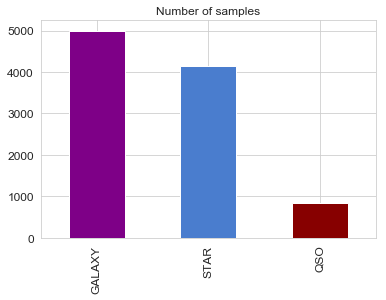

In [6]:
sdss_data['class'].value_counts()
star_color='#4a7dce'
galaxy_color='#7e0087'
qso_color='#870000'
array_color=[star_color, galaxy_color, qso_color]
sdss_data['class'].value_counts().plot(kind='bar',title='Number of samples', color=['#7e0087','#4a7dce','#870000']);

Większość próbek jest skategoryzowanych jako galaktyka (~50%), drugą najliczniejszą kategorią są gwiazdy (~40%), a kwazary stanowią najmniej liczną grupę (~10%).

## Brakujące wartości

In [7]:
columns = sdss_data.columns
percent_missing = sdss_data.isnull().sum() * 100 / len(sdss_data)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing')

column_name  percent_missing
objid           objid              0.0
plate           plate              0.0
redshift     redshift              0.0
class           class              0.0
specobjid   specobjid              0.0
field           field              0.0
camcol         camcol              0.0
rerun           rerun              0.0
run               run              0.0
z                   z              0.0
i                   i              0.0
r                   r              0.0
g                   g              0.0
u                   u              0.0
dec               dec              0.0
ra                 ra              0.0
mjd               mjd              0.0
fiberid       fiberid              0.0

Jak widać nie brakuje żadnych wartości, co oznacza, że nie musimy ani usuwać ani dodawać wartości do naszego zbioru danych.

## Filtracja danych

Już na tym etapie możemy określić, które cechy nie będą w jakikolwiek sposób powiązane z zmienną objaśnianą.

objid oraz specobjid są jedynie identyfikatorami, które były używane do identyfikacji rekordów kiedy jeszcze znajdowały się w bazie danych. Dlatego też nie będziemy ich brać pod uwagę podczas klasyfikacji.

Co więcej, cechy: 'run', 'rerun', 'camcol' oraz 'field' są cechami opisującymi części aparatu w momencie pomiaru obserwacji.

Źródło: http://www.sdss3.org/dr9/imaging/imaging_basics.php

W związku z powyższym usuniemy wyżej wymienione kolumny, gdyż jakikolwiek związek z klasą przynależności byłby przypadkowy.

In [8]:
print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'plate', 'mjd', 'fiberid'], axis=1, inplace=True)
sdss_data.describe()

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


ra           dec             u             g             r  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     175.529987     14.836148     18.619355     17.371931     16.840963   
std       47.783439     25.212207      0.828656      0.945457      1.067764   
min        8.235100     -5.382632     12.988970     12.799550     12.431600   
25%      157.370946     -0.539035     18.178035     16.815100     16.173333   
50%      180.394514      0.404166     18.853095     17.495135     16.858770   
75%      201.547279     35.649397     19.259232     18.010145     17.512675   
max      260.884382     68.542265     19.599900     19.918970     24.802040   

                  i             z      redshift  
count  10000.000000  10000.000000  10000.000000  
mean      16.583579     16.422833      0.143726  
std        1.141805      1.203188      0.388774  
min       11.947210     11.610410     -0.004136  
25%       15.853705     15.618285      0.000081  
50%       16.554985     16.389945      0.042591  
75%       17.258550     17.141447      0.092579  
max       28.179630     22.833060      5.353854

## Wizualizacja danych

In [9]:
leftover_features = ['ra','dec','u','g','r','i','z','redshift']
sdss_data.head()

ra       dec         u         g         r         i         z  \
0  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342  15.22531   
1  183.598371  0.135285  18.66280  17.21449  16.67637  16.48922  16.39150   
2  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732  16.80125   
3  183.870529  0.049911  17.76536  16.60272  16.16116  15.98233  15.90438   
4  183.883288  0.102557  17.55025  16.26342  16.43869  16.55492  16.61326   

    class  redshift  
0    STAR -0.000009  
1    STAR -0.000055  
2  GALAXY  0.123111  
3    STAR -0.000111  
4    STAR  0.000590

## Analiza jednoczynnikowa
Będą nas głównie interesować histogramy 'redshift'. Reszta histogramów została tu przedstawiona tylko w celach poglądowych. Nie widać na nich nic co było by dla nas godne uwagi.

### Histogramy

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D0FAF28DA0>,
      dtype=object)

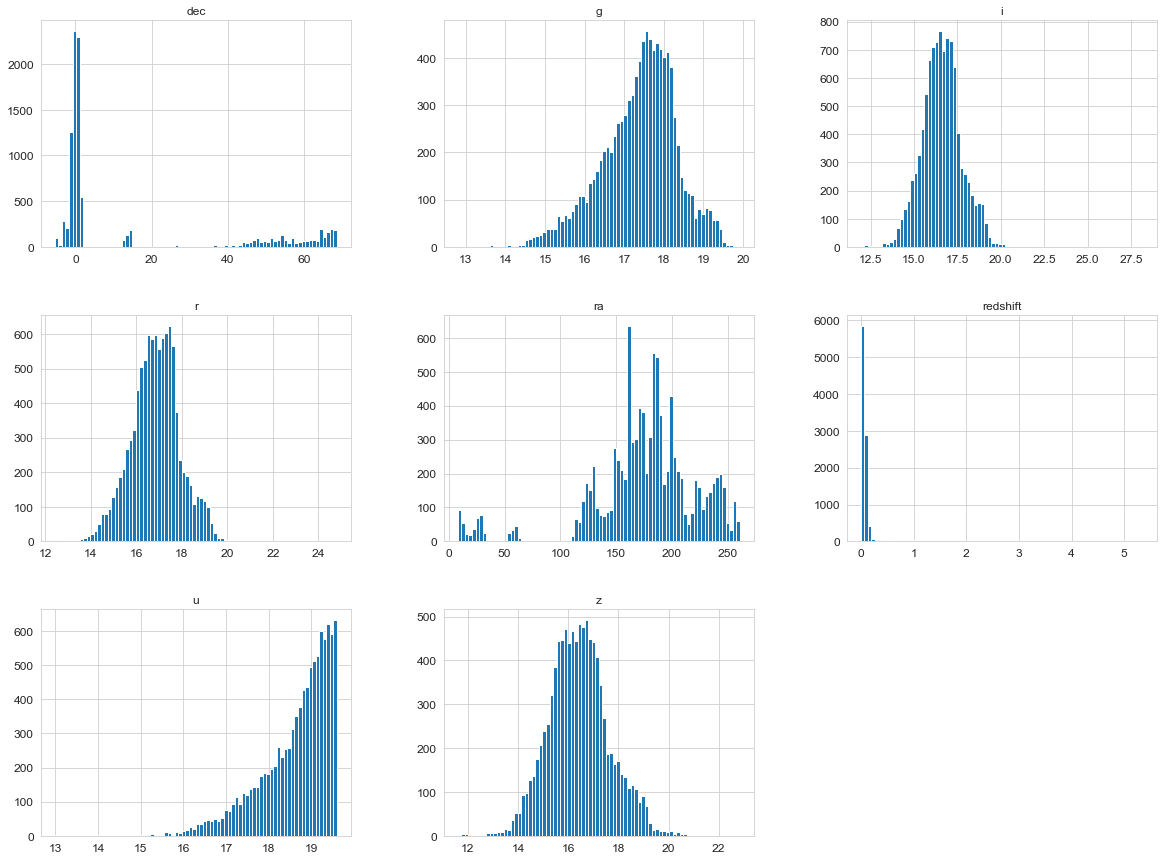

In [10]:
sdss_data.hist(bins=80, figsize=(20,15))

Już tu widzimy że dane zdecydowanie nie mają rozkładu normalnego. Konieczne tu będzie zastosowanie normalizacji Min-Max lub standaryzacji.

### Redshift

By przeprowadzić analizę uniwariatywną zaczniemy od histogramów dla cechy 'redshift' dla każdej z klas. Powie nam to w jaki sposób przesunięcie ku czerwieni jest zdystrybuowane wśród klas.

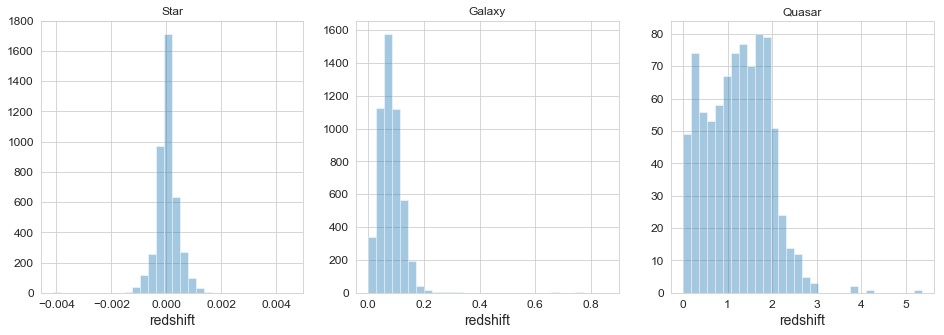

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 5))
ax = sns.distplot(sdss_data[sdss_data['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_data[sdss_data['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_data[sdss_data['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

Widzimy, że wartości przesunięcia ku czerwieni znacząco różnią się pośród klas. 

* Gwiazdy - widzimy, że histogram przypomina rozkład normalny o średniej u=0
* Galaktyki - tutaj wartości wydają się pochodzić z rozkładu normalnego o nieco cięższym prawym ogonie. Rozkład ten ma średnią wartość wokół punktu 0.075.
* Kwazary - wartości przesunięcia ku czerwieni są o wiele bardziej jednorodnie rozproszone, niż w przypadku gwiazd i galaktyk. Są one mniej więcej równo rozproszone w przedziale od 0 do 3, później ich występowanie zdaje się zanikać drastycznie. Blisko wartości 4 i 5 mamy parę wartości odstających.

### Rektascensja

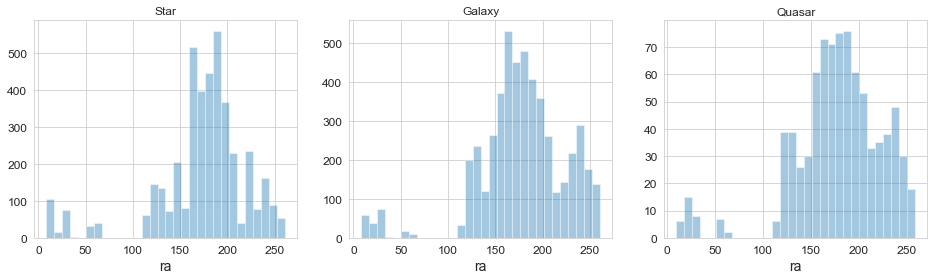

In [12]:
# Right Ascension
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(sdss_data[sdss_data['class']=='STAR'].ra, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_data[sdss_data['class']=='GALAXY'].ra, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_data[sdss_data['class']=='QSO'].ra, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

### Deklinacja

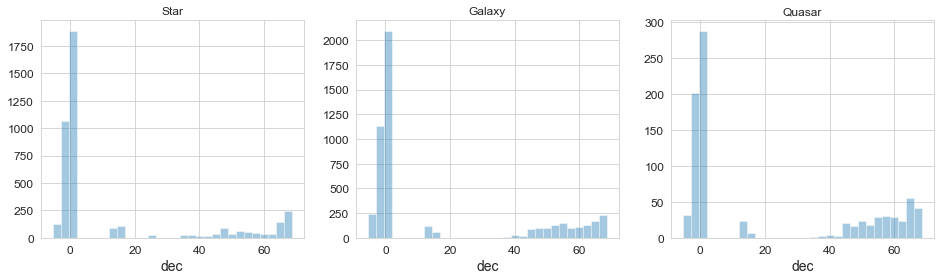

In [13]:
# Declination
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(sdss_data[sdss_data['class']=='STAR'].dec, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_data[sdss_data['class']=='GALAXY'].dec, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_data[sdss_data['class']=='QSO'].dec, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

### Pasmo U

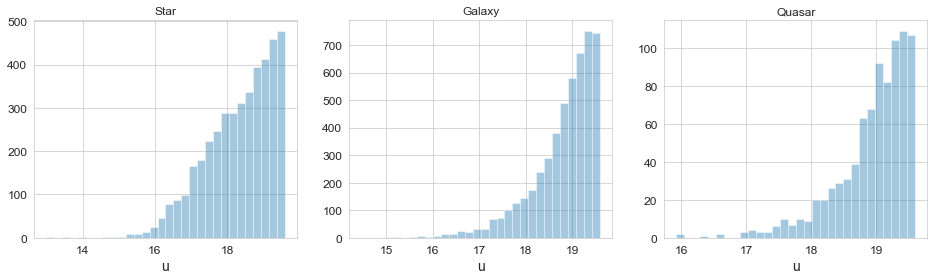

In [14]:
# U
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(sdss_data[sdss_data['class']=='STAR'].u, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_data[sdss_data['class']=='GALAXY'].u, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_data[sdss_data['class']=='QSO'].u, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

### Pasmo G

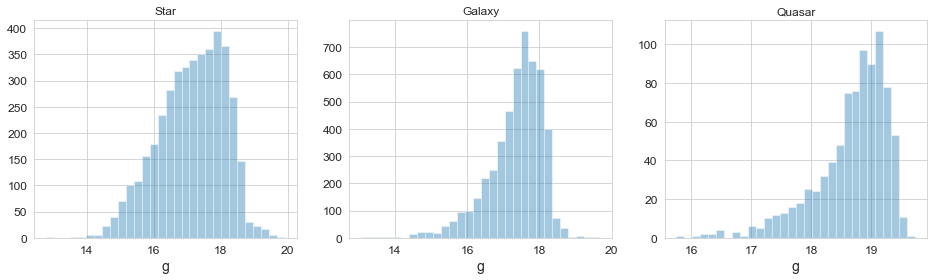

In [15]:
# G
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(sdss_data[sdss_data['class']=='STAR'].g, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_data[sdss_data['class']=='GALAXY'].g, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_data[sdss_data['class']=='QSO'].g, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

### Pasmo R

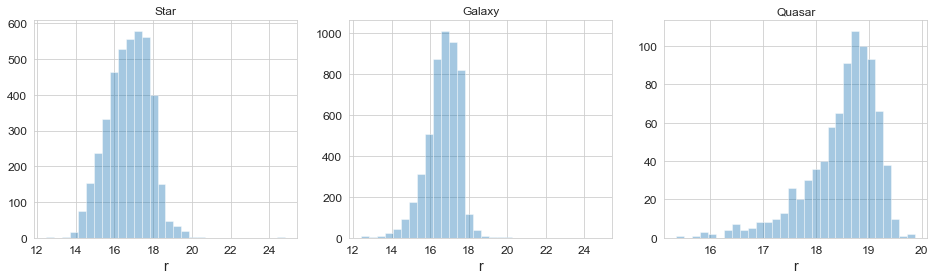

In [16]:
# R
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(sdss_data[sdss_data['class']=='STAR'].r, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_data[sdss_data['class']=='GALAXY'].r, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_data[sdss_data['class']=='QSO'].r, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

### Pasmo I

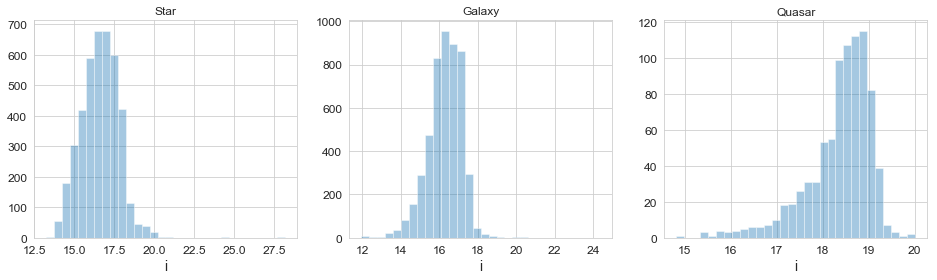

In [17]:
# I
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(sdss_data[sdss_data['class']=='STAR'].i, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_data[sdss_data['class']=='GALAXY'].i, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_data[sdss_data['class']=='QSO'].i, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

### Pasmo Z

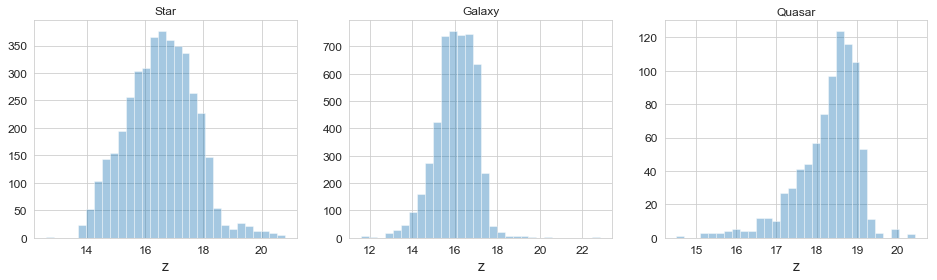

In [18]:
#Z
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(sdss_data[sdss_data['class']=='STAR'].z, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_data[sdss_data['class']=='GALAXY'].z, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_data[sdss_data['class']=='QSO'].z, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

## Wykresy pudełkowe

In [125]:
axe_indexes = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
zipped = list(zip(axe_indexes, leftover_features))
print(zipped)

[((0, 0), 'ra'), ((0, 1), 'dec'), ((0, 2), 'u'), ((0, 3), 'g'), ((1, 0), 'r'), ((1, 1), 'i'), ((1, 2), 'z'), ((1, 3), 'redshift')]


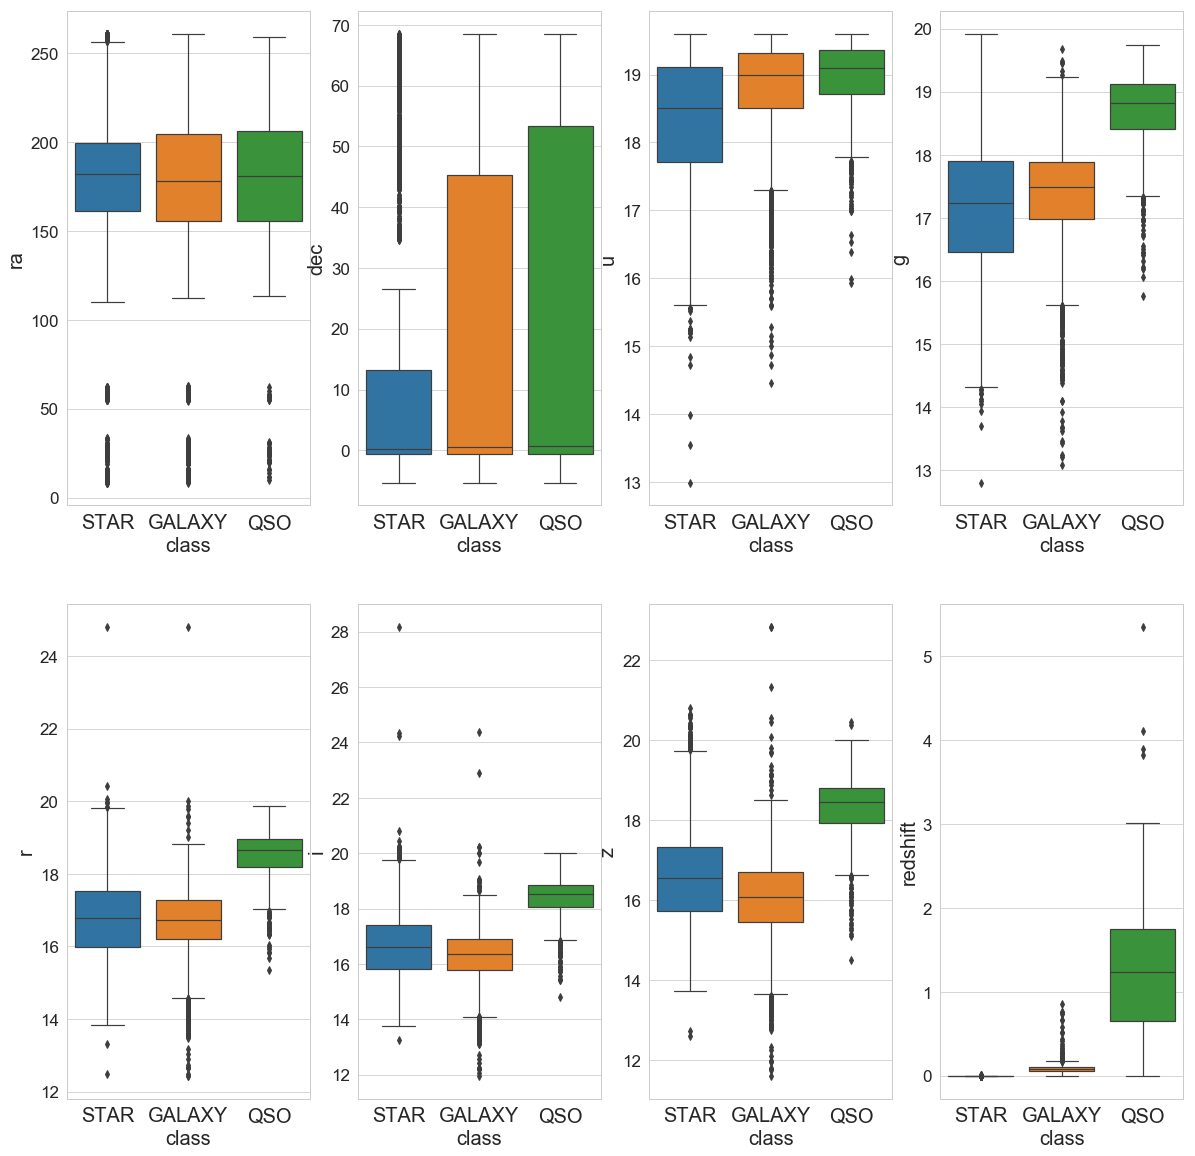

In [158]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,20))
for indexes, feature in zipped:
    sns.set_context("paper", rc={"font.size":15,
                                 "axes.titlesize":15,
                                 "axes.labelsize":20,
                                 "xtick.labelsize":20,
                                 "ytick.labelsize":17,
                                 "legend.fontsize":17})      
    sns.boxplot(x="class", y=feature, data=sdss_data, ax=axes[indexes[0], indexes[1]])

Retkascensja: Dane rozłożone są w bardzo podobny sposób w przypadku wszystkich 3 klas. Możemy zaobserwować nagromadzenie obserwacji odstających, mających wartości w przedziale [0-50]. Więcej jest ich w przypadku gwiazd i galaktyk niż w przypadku kwazarów, ale to wynika raczej z faktu że kwazary zwyczajnie są rzadsze niż inne obiekty.

Deklinacja: Wykresy są podobne dla Galaktyk i Kwazarów, ale wykres dla gwiazd różni się diametralnie. Mamy tutaj bardzo dużo obserwacji odstających. Praktycznie wszystko co ma wartość większą od 2.0 jest tutaj obserwacją odstającą.

Pasma u, g, r, i, z: Występują wyraźne różnice pomiędzy klasami - zwłaszcza pomiędzy kwazarami a innymi klasami. Wygląda na to że jeśli chodzi o te cechy to kwazary mają większe wartości pasm niż reszta klas. Możemy też zaobserwować sporo obserwacji odstających - zwłaszcza w dolnych zakresach wartości.

Przesunięcie ku czerwieni: Kwazary ewidentnie odstają tutaj od galaktyk i gwiazd. Przy czym praktycznie wszystkie gwiazdy mają tutaj wartości tej cechy oscylujące wokół zera. Wynika to zapewne z faktu, że większość gwiazd obserwowanych na nocnym niebie należy do Drogi Mlecznej. Rozrzut wartości tej cechy dla poszczególnych klas może sugerować, że będzie ona miała znaczący wpływ w procesie klasyfikacji. 

## Analiza wieloczynnikowa

### Wykresy rozrzutu

<Figure size 432x288 with 0 Axes>

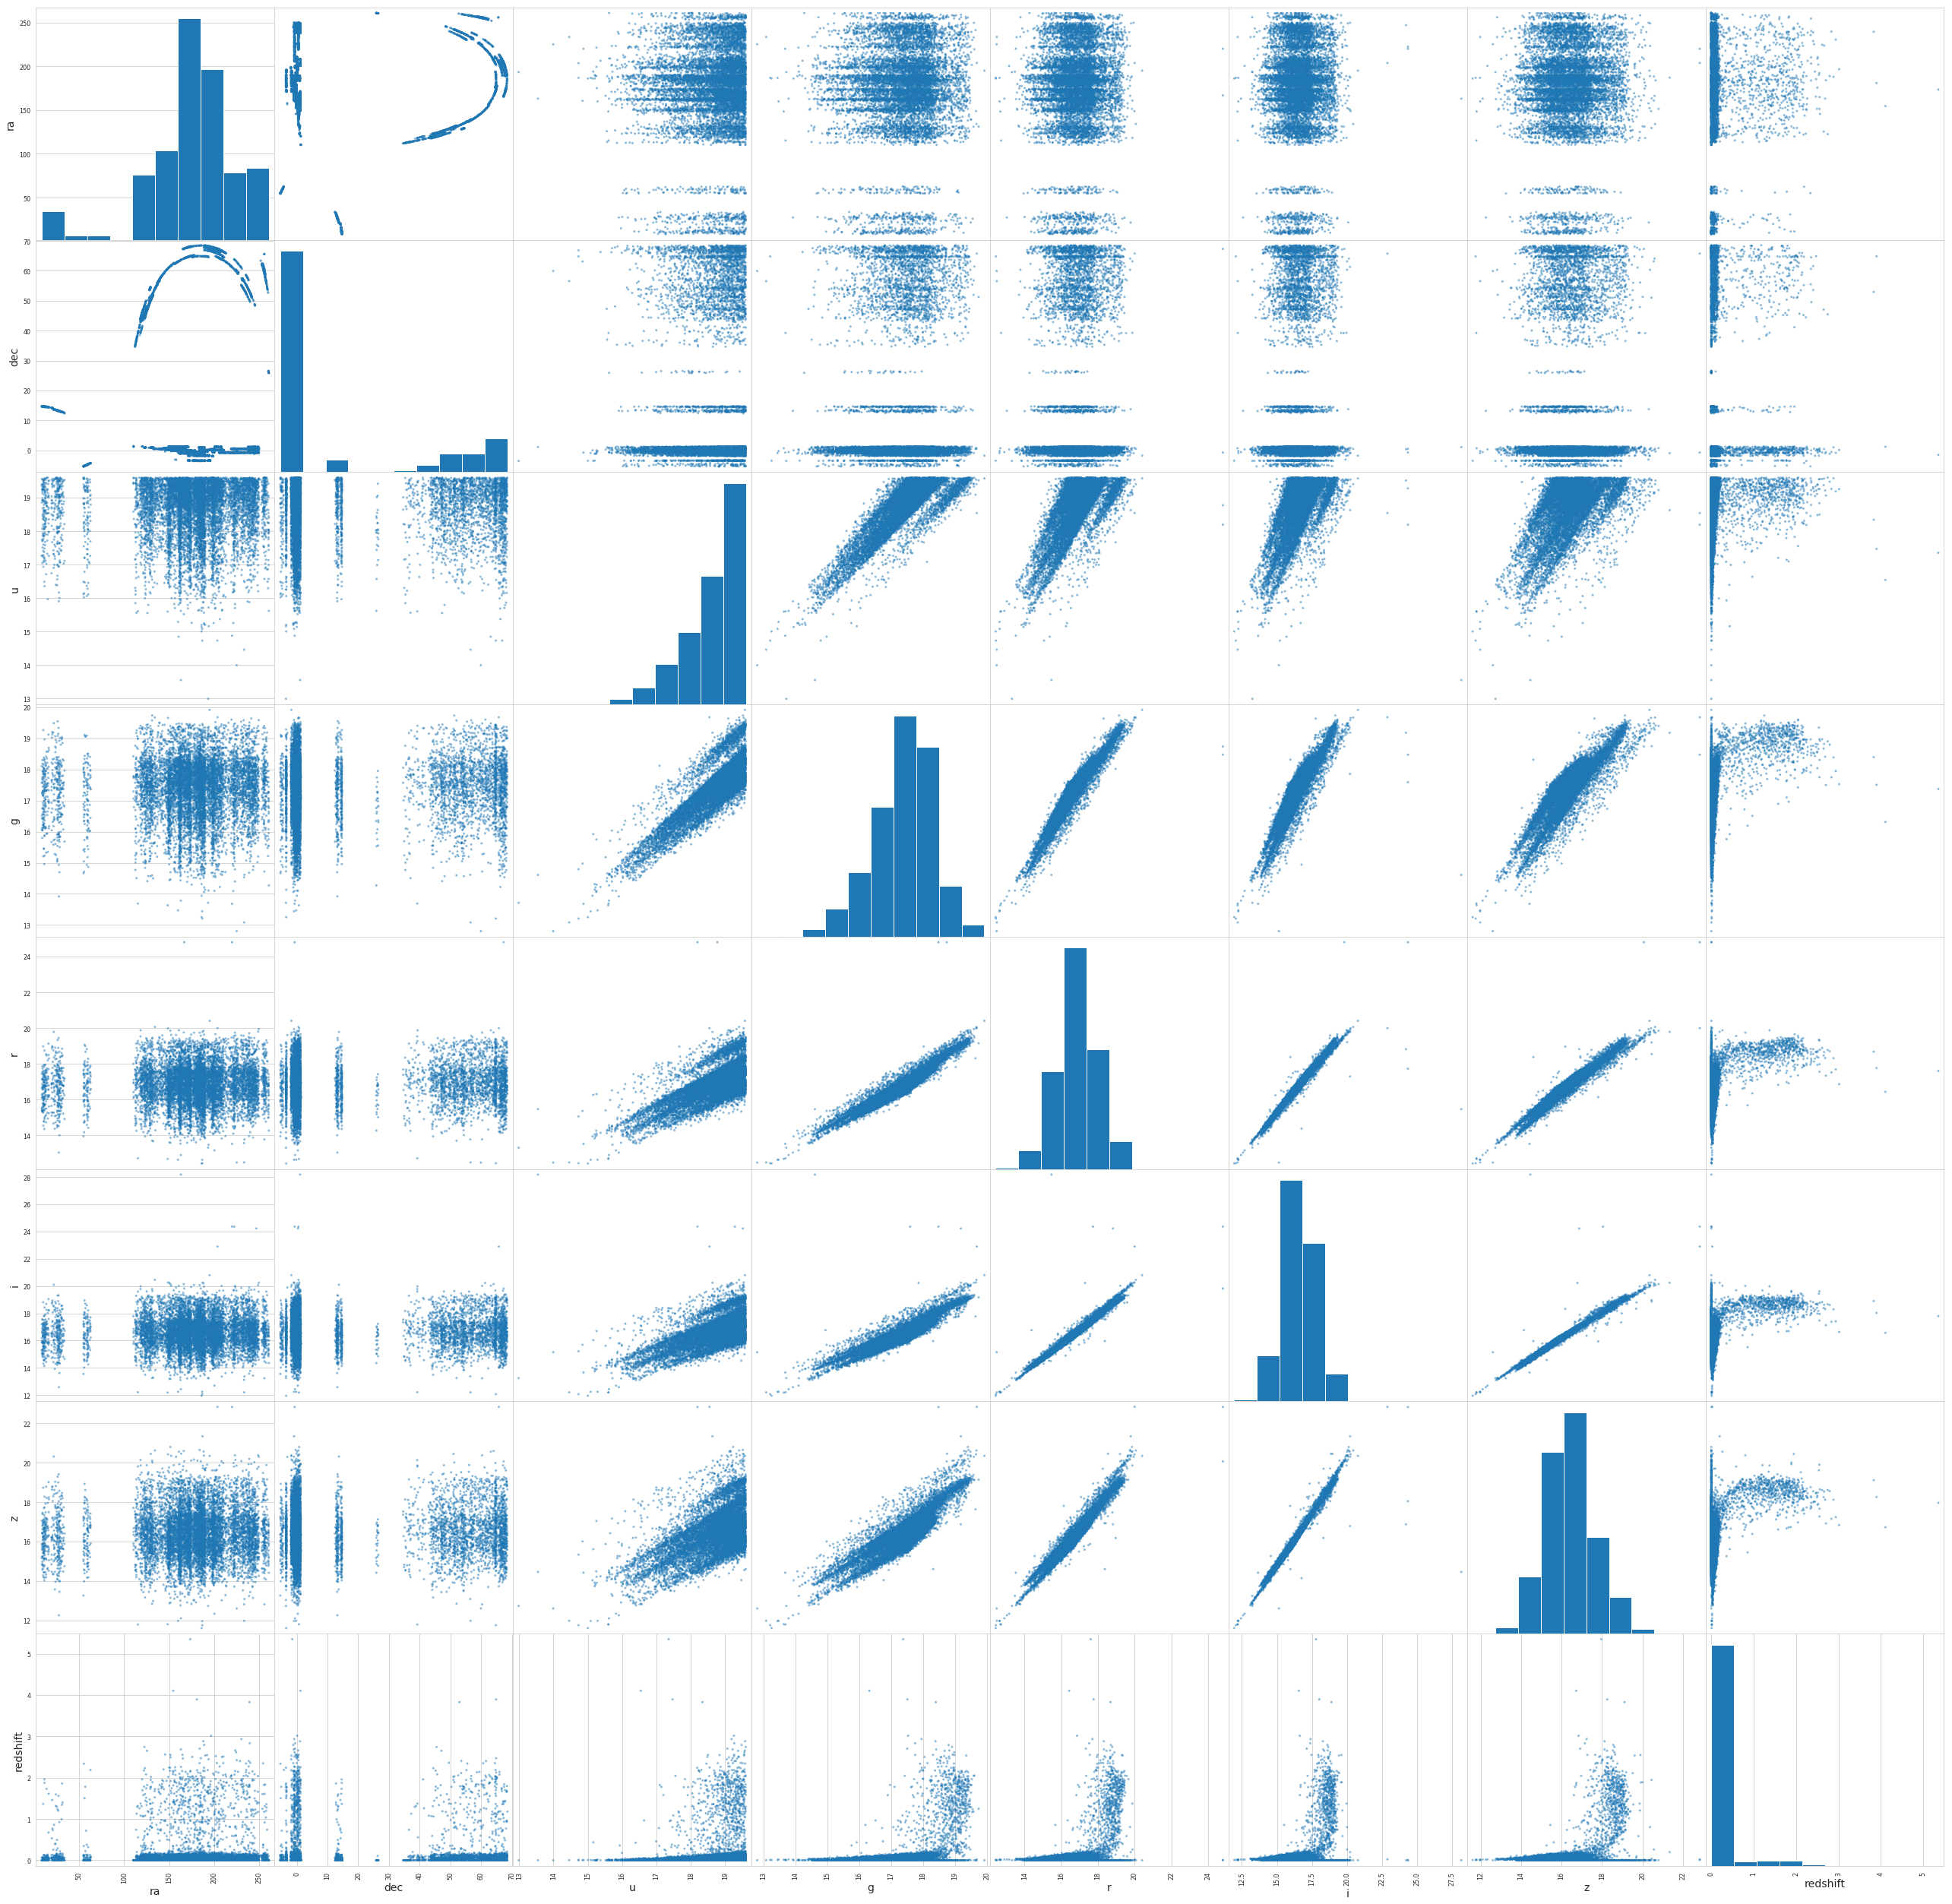

<Figure size 432x288 with 0 Axes>

In [19]:
# scatter plot matrix
pd.plotting.scatter_matrix(sdss_data,figsize=(45,45))
plt.figure()

Zgrupowanie punktów na przekątnych oznacza wysoką korelację pomiędzy zmiennymi. Możemy to zaobserwować głównie pomiędzy zmiennymi reprezentującymi różne pasma światła. 

### Wykresy typu "Pair Plot"

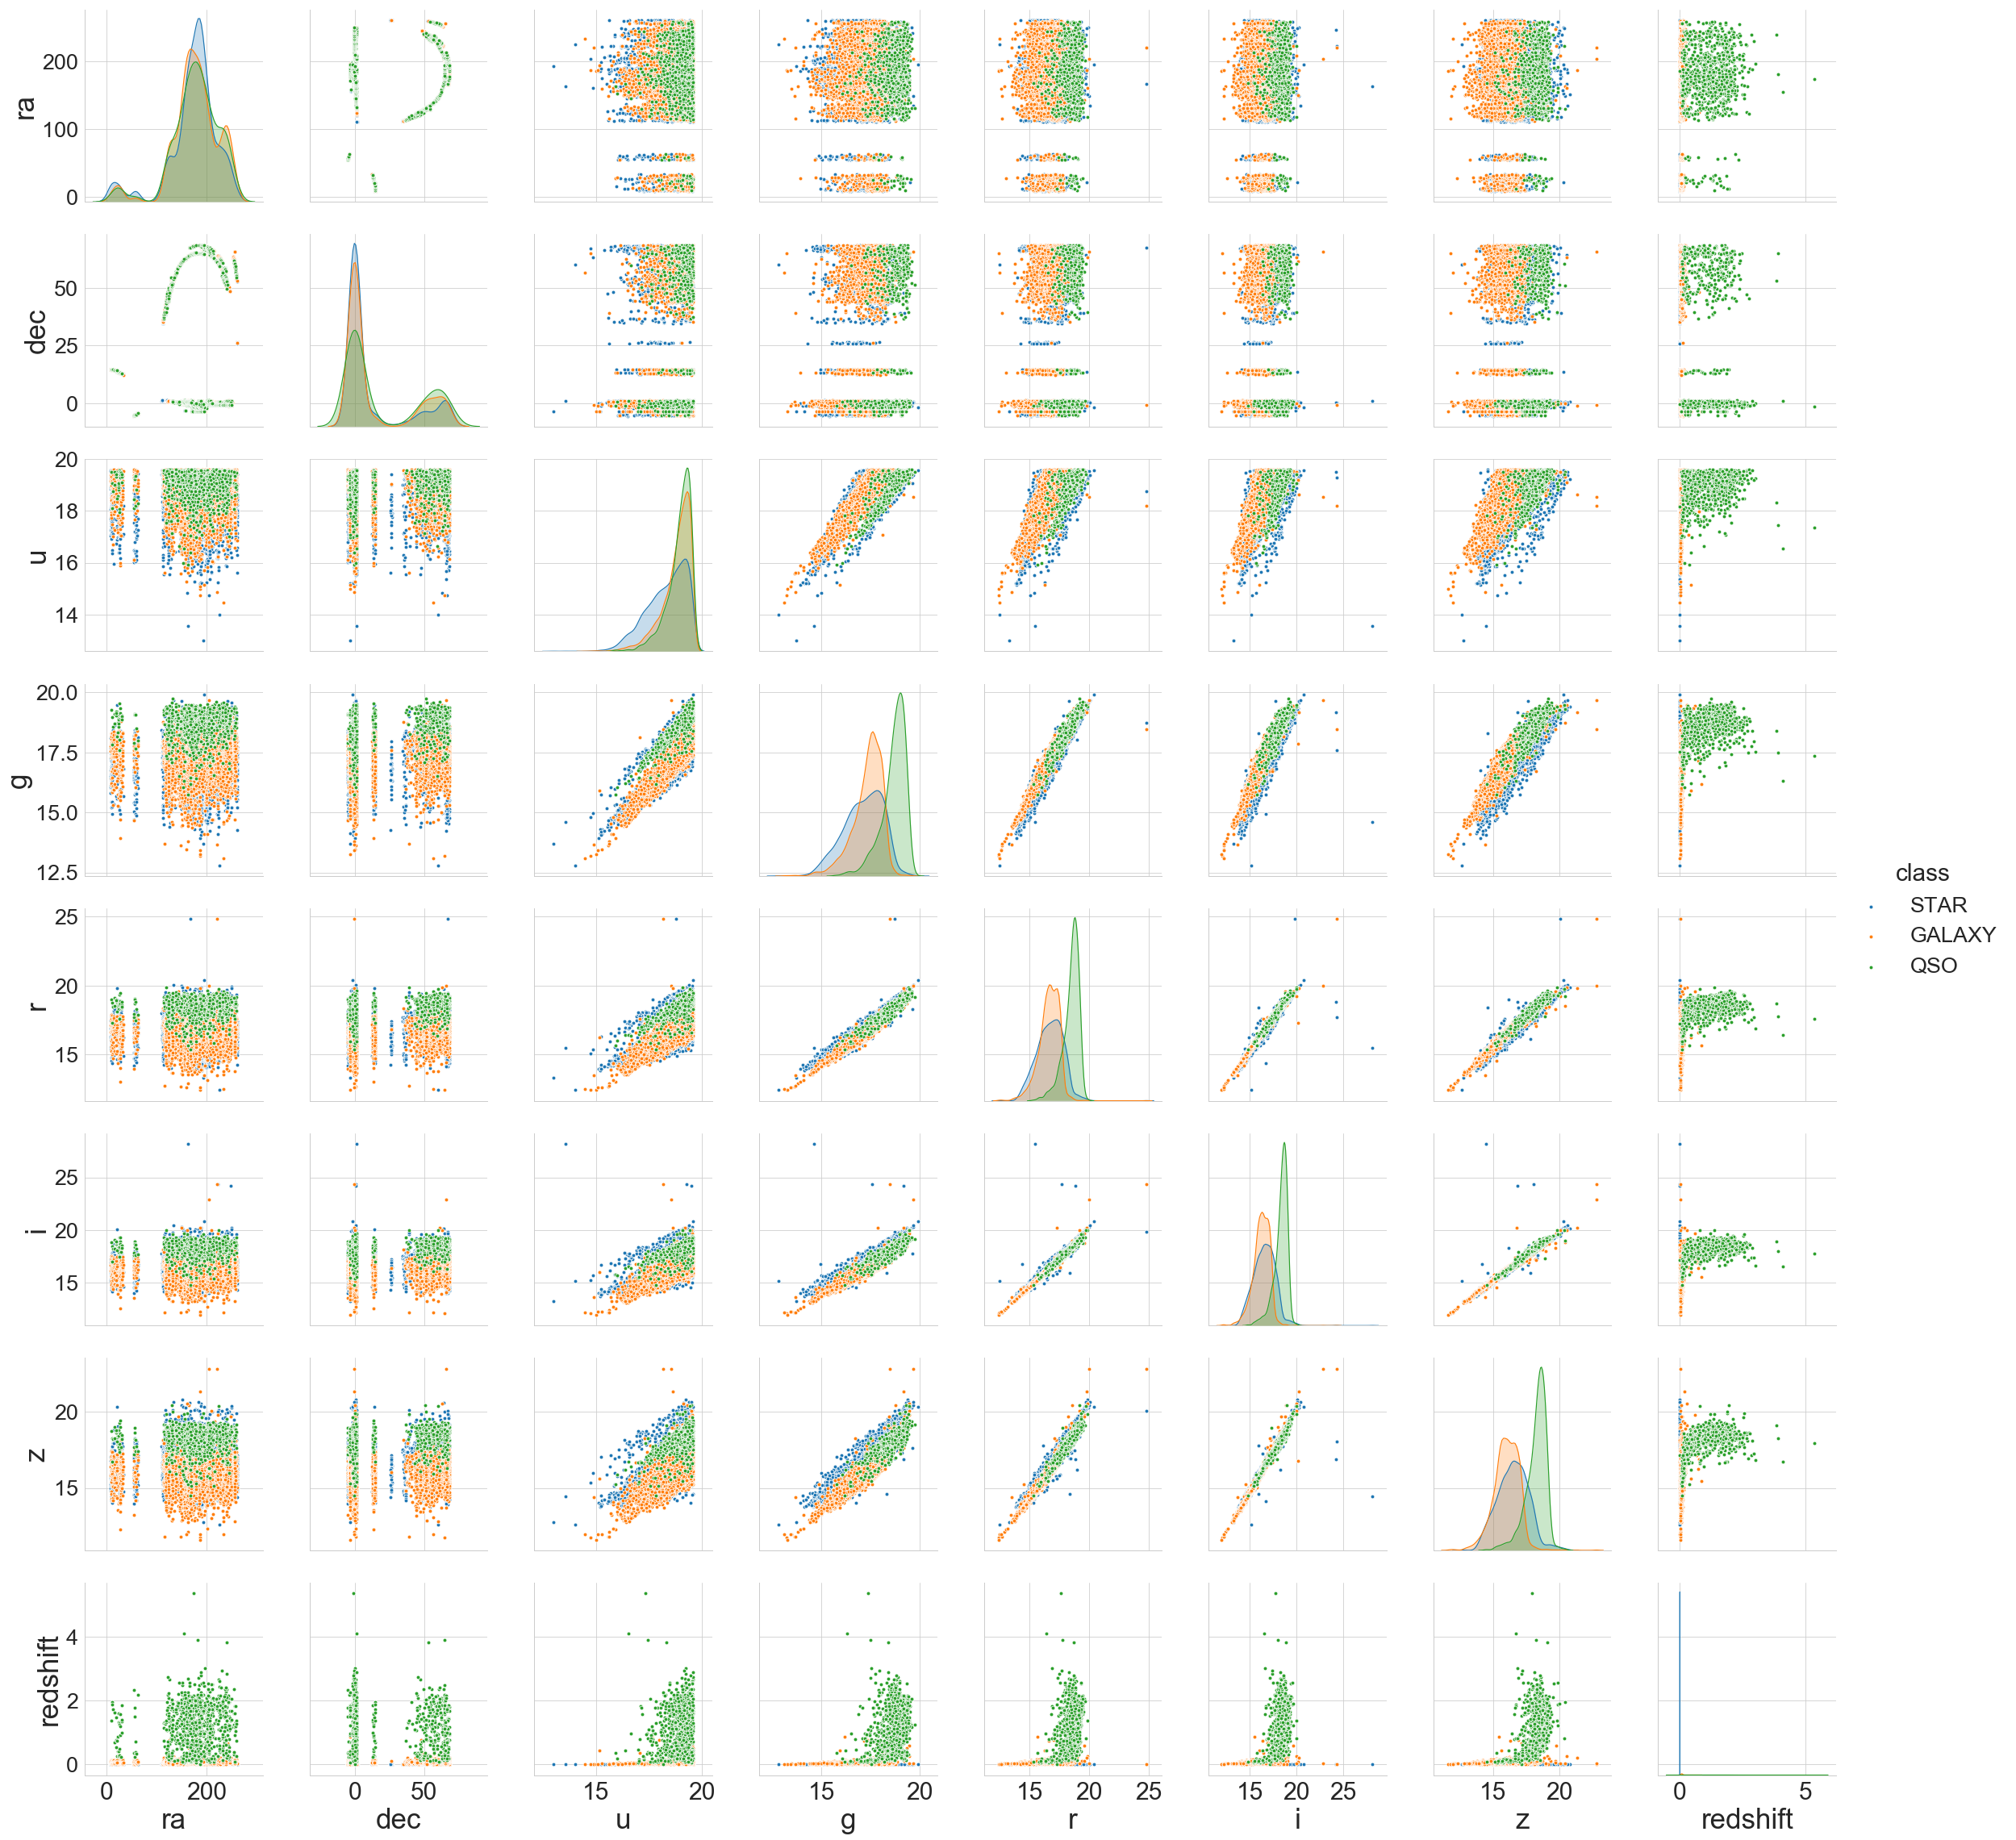

In [161]:
# Using seaborn pairplot to see the bivariate relation between each pair of features
sns.set_context("paper", rc={"font.size":15,
                             "axes.titlesize":15,
                             "axes.labelsize":35,
                             "xtick.labelsize":30,
                             "ytick.labelsize":27,
                             "legend.fontsize":27})      
sns.pairplot(sdss_data, hue="class", height=4)

Pairplot z biblioteki Seaborn daje dużo lepszy wgląd w dane. Możemy zaobserwować teraz w jaki sposób dane są rozprzestrzenione pomiędzy klasami. 

Ponownie widzimy silne związki pomiędzy poszczególnymi pasmami światła. Można by się tu pokusić o wykorzystanie Analizy Głównych Składowych i redukcję wymiarowości.

### Pozycja na niebie

Text(0.5, 1.0, 'Equatorial coordinates')

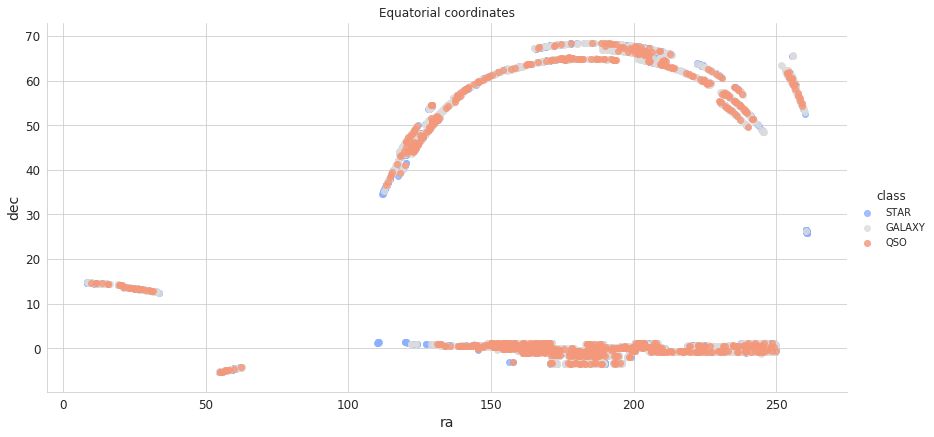

In [21]:
sns.lmplot(x='ra', y='dec', data=sdss_data, hue='class', fit_reg=False, palette='coolwarm', height=6, aspect=2)
plt.title('Equatorial coordinates')

Jak widać, współrzędne równikowe nie różnią się za bardzo pomiędzy klasami. Jest kilka obserwacji odstających ale większość obiektów występuje w tych samych obszarach.

Dlaczego?

Ma to związek z tym jak prowadzone były obserwacje. Zdjęcia SDSS pokrywają te same części nocnego nieba. Wykres powyżej mówi nam, że wszystkie klasy pokrywają w równym stopniu obserwowane obszary. Badając jeden fragment nieba mamy równe szanse za znalezienie w nim zarówno gwiazd, galaktyk czy też kwazarów.

### Korelacja zmiennych

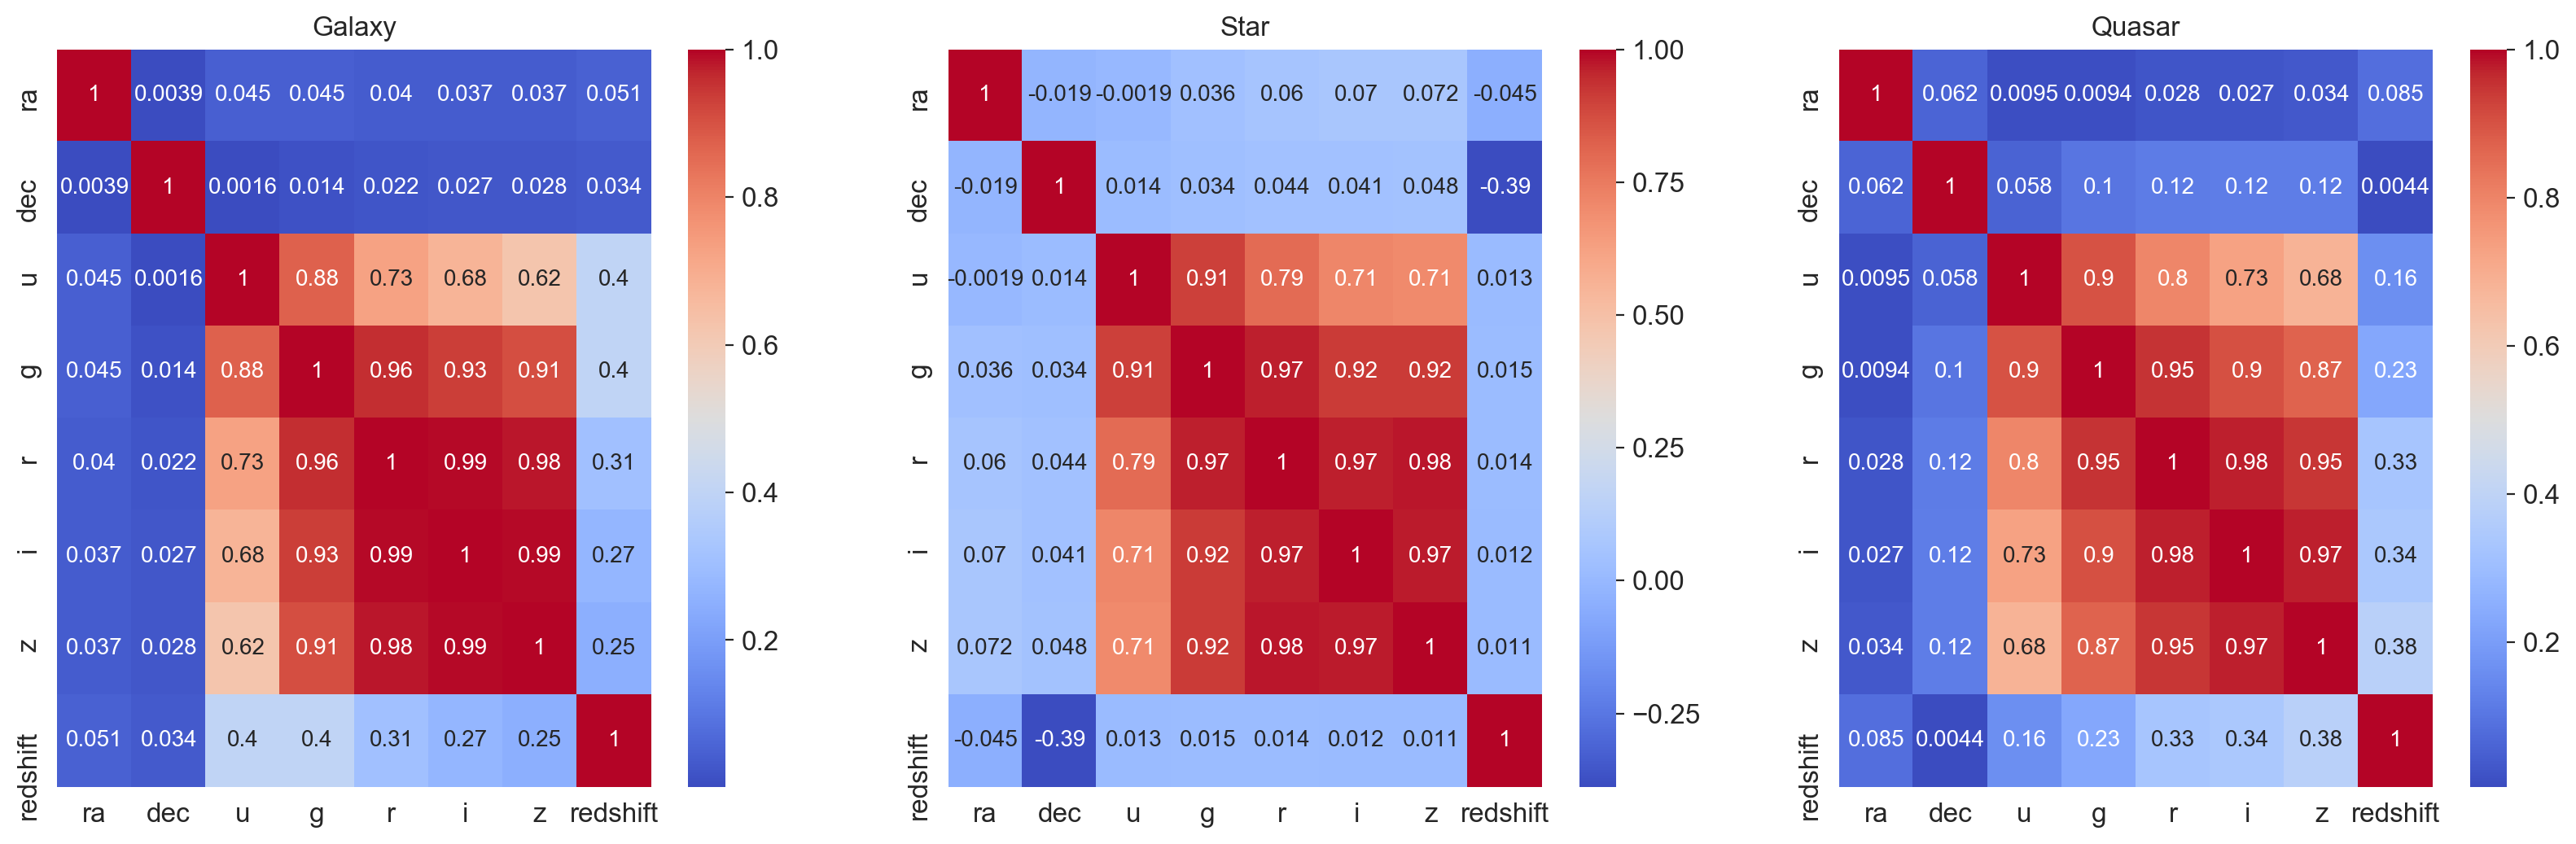

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 6))
fig.set_dpi(200)
ax = sns.heatmap(sdss_data[sdss_data['class']=='GALAXY'][['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']].corr(), ax = axes[0], cmap='coolwarm', annot=True)
ax.set_title('Galaxy')
ax = sns.heatmap(sdss_data[sdss_data['class']=='STAR'][['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']].corr(), ax = axes[1], cmap='coolwarm', annot=True)
ax.set_title('Star')
ax = sns.heatmap(sdss_data[sdss_data['class']=='QSO'][['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']].corr(), ax = axes[2], cmap='coolwarm', annot=True)
ax = ax.set_title('Quasar')

Macierze korelacji jedynie potwierdzają wcześniejsze domniemania o silnej korelacji pomiędzy pasmami światła. Możemy później użyć PCA do zredukowania wymiarowości i przyśpieszenia uczenia naszych modeli. Redukcja z 5 pasm do 3 składowych wygenerowanych przez PCA powinna w zupełności wystarczyć.

## PCA

Wyjaśnialna wariancja

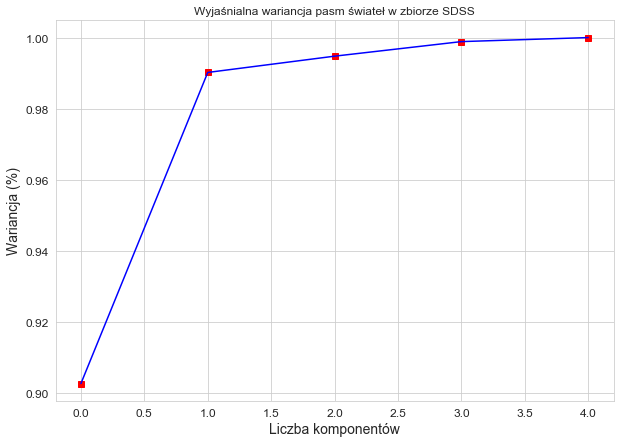

In [32]:
from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator

#Fitting the PCA algorithm with our Data
pca = PCA().fit(sdss_data[['u', 'g', 'r', 'i', 'z']])
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'rs',np.cumsum(pca.explained_variance_ratio_), '-b')
plt.xlabel('Liczba komponentów')
plt.ylabel('Wariancja (%)') #for each component
plt.title('Wyjaśnialna wariancja pasm świateł w zbiorze SDSS')
plt.show()

In [33]:
sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

ra       dec   class  redshift     PCA_1     PCA_2     PCA_3
0  183.531326  0.089693    STAR -0.000009 -1.507202 -1.377293 -0.265119
1  183.598371  0.135285    STAR -0.000055 -0.195758 -0.028410 -0.155695
2  183.680207  0.126185  GALAXY  0.123111  1.297604 -0.590023  0.140338
3  183.870529  0.049911    STAR -0.000111 -1.446117  0.566685 -0.009272
4  183.883288  0.102557    STAR  0.000590 -0.849271  1.287505 -0.397689

## Normalizacja

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

transformed = scaler.fit_transform(sdss_data.drop('class', axis=1)).astype(float)

new_df = pd.DataFrame(transformed, columns=leftover_features)

In [44]:
new_df['class'] = sdss_data['class']
new_df.head(3)

ra       dec         u         g         r         i         z  \
0  0.167458 -0.584923  1.031486 -0.348559 -0.837280 -0.946058 -0.995342   
1  0.168862 -0.583114  0.052430 -0.166533 -0.154155 -0.082645 -0.026043   
2  0.170574 -0.583475  0.921568  0.867093  0.593154  0.441201  0.314528   

   redshift   class  
0 -0.369731    STAR  
1 -0.369849    STAR  
2 -0.053027  GALAXY